<a href="https://colab.research.google.com/github/nicollasro/Echochamber/blob/main/Webscraping_(Streaming)_%2B_Processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{'created_at': 'Sun Nov 06 07:22:59 +0000 2022', 'id': 1589156376181456899, 'id_str': '1589156376181456899', 'text': 'RT @figueiredokelly: Kkkkkk eu tive que dar um print. \nO bolsonarista está convicto de que a aparição de OVNIs tem ligação com as manifesta…', 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1486562559880744963, 'id_str': '1486562559880744963', 'name': 'Sol Lula Da Silva 🚩❤️', 'screen_name': 'Solange81166745', 'location': None, 'url': None, 'description': '#LulaPresidente13 em 2022 e no primeiro turno.                 CONTA NOVA, pq a outra o Twitter derrubou.', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 2427, 'friends_count': 2898, 'listed_count': 1, 'favourites_count': 33720, 'statuses_

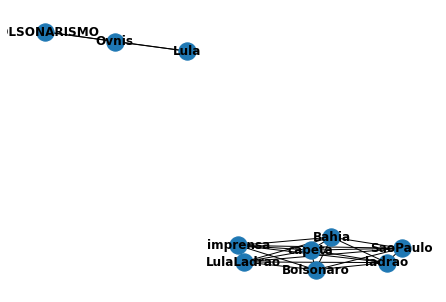

{'created_at': 'Sun Nov 06 07:24:09 +0000 2022', 'id': 1589156670311387136, 'id_str': '1589156670311387136', 'text': 'RT @courant_AetR: Présidentielle au Brésil : Bolsonaro dehors, les travailleurs devront prendre la rue sous Lula !\n\n👉 Lire la suite sur not…', 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1483960339473616898, 'id_str': '1483960339473616898', 'name': 'Armelle Pertus', 'screen_name': 'armelle_pertus', 'location': None, 'url': 'https://www.facebook.com/armellepertus/', 'description': 'Armelle Pertus porte-parole @NPA_officiel +campagne présidentielle @philippe_poutou •Prof des écoles à Gennevillers~ syndicaliste /membre @NPA_92 @courant_AetR', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 4

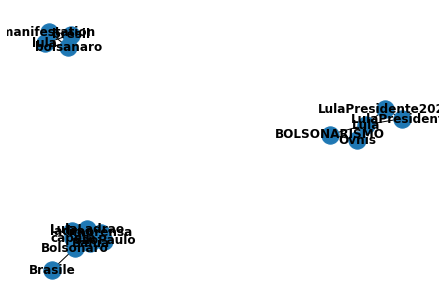

In [8]:
from math import sqrt

from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from json import dumps, loads


import os
import six
import time
import itertools
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler("jvqVFmtJH34Ft9laJygimyIo0", "URO3cDvgTY6HjFvnCMQ925ebwpoMp48lRzmiTYYubM5XPMQVjy")
        auth.set_access_token("1173637793379160067-2qZT07Jdmk20jfv0Mc0WzTZHAt50UE", "745ND9hc5TPTMYD5EqObeZW9EC5nmYKHd0cK42fI7t2as")
        return auth

class TwitterStreamer():
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, filename, hashtags, duration):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(filename,duration)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener,tweet_mode='extended')

        stream.filter(track=hashtags)

class TwitterListener(StreamListener):
    def __init__(self, filename, duration=1):
        self.start_time = time.time()
        self.limit = duration*3600
        self.filename = filename
        self.df = pd.DataFrame(columns=['id','created_at','source','screen_name','full_text','lang','favorite_count','hashtags'])

    def on_data(self, data):
        try:
            if (time.time() - self.start_time) < self.limit:
                tweet = loads(data)
                new_entry=[]
                print(tweet)
                new_entry += [tweet['id'], tweet['created_at'],tweet['source'],tweet['user']['screen_name']]
                if 'extended_tweet' in tweet.keys():
                    new_entry += [tweet['extended_tweet']['full_text']]
                    hashtags = ", ".join([hashtag_item['text'] for hashtag_item in tweet['extended_tweet']['entities']['hashtags']])
                elif 'retweeted_status' in tweet.keys():
                    if 'extended_tweet' in tweet['retweeted_status'].keys():
                        new_entry += [tweet['retweeted_status']['extended_tweet']['full_text']]
                        hashtags = ", ".join([hashtag_item['text'] for hashtag_item in tweet['retweeted_status']['extended_tweet']['entities']['hashtags']])
                    else:
                        new_entry += [tweet['retweeted_status']['quoted_status']['extended_tweet']['full_text']]
                        hashtags = ", ".join([hashtag_item['text'] for hashtag_item in tweet['retweeted_status']['quoted_status']['extended_tweet']['entities']['hashtags']])
                else:
                    new_entry +=[tweet['text']]
                    hashtags = ", ".join([hashtag_item['text'] for hashtag_item in tweet['entities']['hashtags']])
                    

                new_entry += [tweet['lang'],tweet['favorite_count']]
                new_entry.append(hashtags)
                single_tweet_df = pd.DataFrame([new_entry])
                single_tweet_df.columns=self.df.columns
                self.df = pd.concat([self.df, single_tweet_df])
                return True

            else:
                csvFile = open(self.filename, 'w' ,encoding='utf-8')
                self.df.to_csv(csvFile, mode='w', columns=self.df.columns, index=False, encoding="utf-8")
                return False

        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            csvFile = open(self.filename, 'w' ,encoding='utf-8')
            self.df.to_csv(csvFile, mode='w', columns=self.df.columns, index=False, encoding="utf-8")
            return False
        print(status)

class Processing_Pipeline():
    def __init__(self,filename):
        self.df = pd.read_csv(filename,header=0)

    def Graph_Creator(self):
    	df=self.df
    	G= nx.Graph()
    	for index, row in df.iterrows():
    		hashtag_list = str(row['hashtags']).replace(' ','').split(',')
    		G.add_nodes_from(hashtag_list)
    		if len(hashtag_list)>=2:
    			pair_of_hashtags = list(itertools.combinations(range(len(hashtag_list)), 2))
    			for pair in pair_of_hashtags:
    				G.add_weighted_edges_from([(hashtag_list[pair[0]],hashtag_list[pair[1]],1)])
    	return G

    def Graph_Appender(self, G):

    	for index, row in self.df.iterrows():
    		hashtag_list = str(row['hashtags']).replace(' ','').split(',')
    		G.add_nodes_from(hashtag_list)
    		if len(hashtag_list)>=2:
    			pair_of_hashtags = list(itertools.combinations(range(len(hashtag_list)), 2))
    			for pair in pair_of_hashtags:
    				G.add_weighted_edges_from([(hashtag_list[pair[0]],hashtag_list[pair[1]],1)])
    	return G

    def Plot_Graph(self,G):
    	print("Número de Hashtags/Nós Distintas(os):", nx.number_of_nodes(G))
    	pos = nx.fruchterman_reingold_layout(G)
    	labels = nx.get_edge_attributes(G,'weight')
    	nx.draw(G,pos, with_labels=True, font_weight='bold')
    	plt.show()

if __name__ == '__main__':

    hashtags = ["#Lula", "#Bolsonaro", "#Globolixo"]
    filename = "Cap"
    cycles = 2
    duration = 0.02 #Fração de uma hora
    for cycle in range(cycles):
        file = filename+'_'+str(cycle)+'.csv'
        interruption = True
        while interruption:
	        try:
	            twitter_streamer = TwitterStreamer()
	            twitter_streamer.stream_tweets(file,hashtags,duration)
	            interruption = False
	        except:
	            print('Twitter Streamer Error')
	            interruption = True
	            print('Waiting')
	            time.sleep(10)
        pipeline = Processing_Pipeline(filename=file)
        if cycle == 0:
            Graph_BBB = pipeline.Graph_Creator(dataset_type='bbb')
            pipeline.Plot_Graph(Graph_BBB)
        else:
            Graph_BBB = pipeline.Graph_Appender(G=Graph_BBB)
            pipeline.Plot_Graph(Graph_BBB)